In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import matplotlib.pyplot as plt

In [2]:
mi.set_variant("llvm_ad_mono_polarized")

In [3]:
import sionna.rt as rt

In [4]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

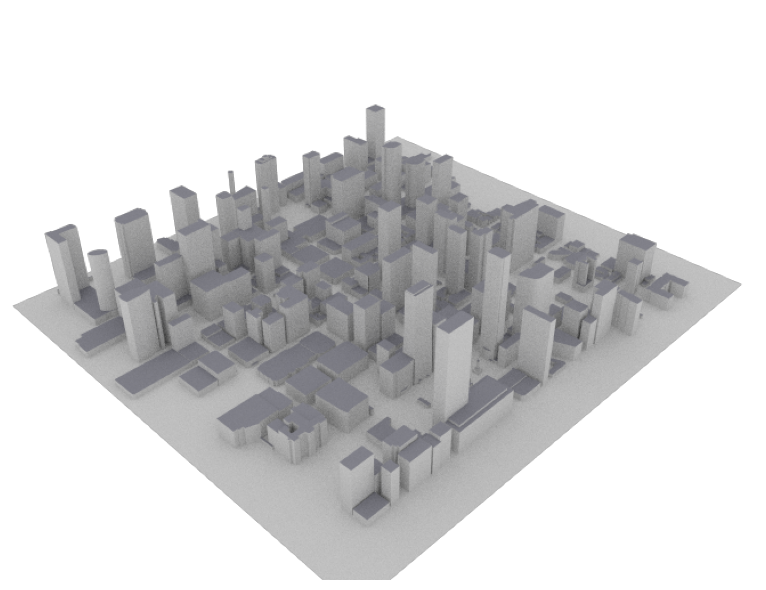

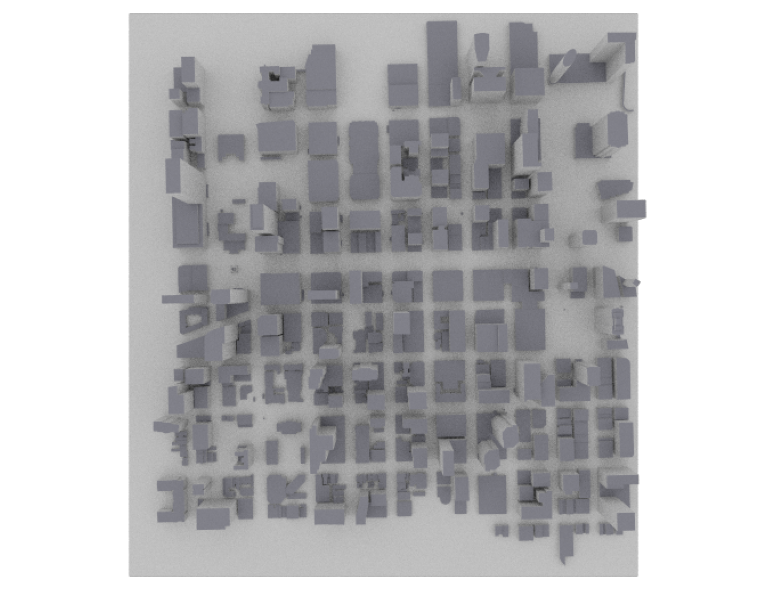

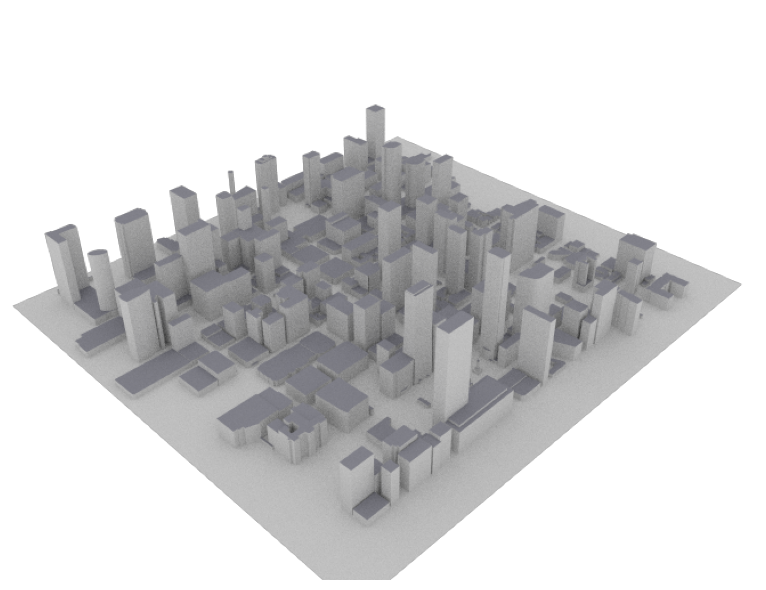

In [5]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

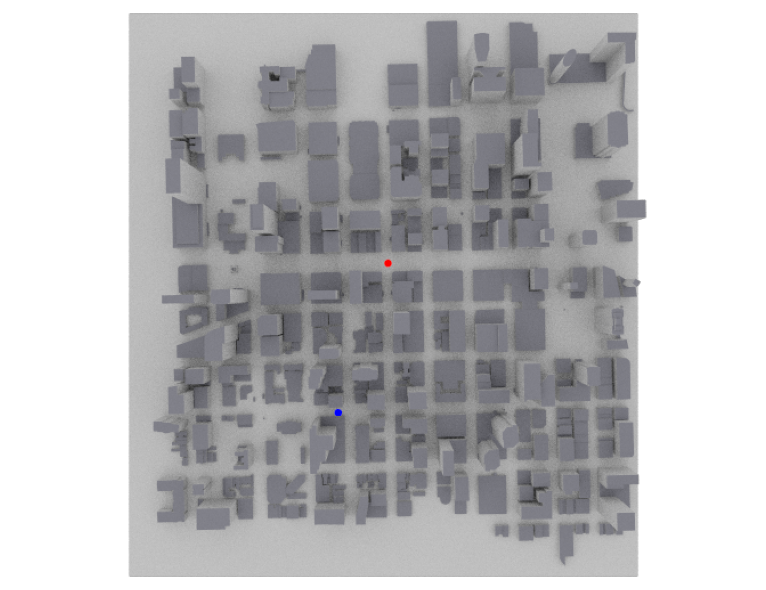

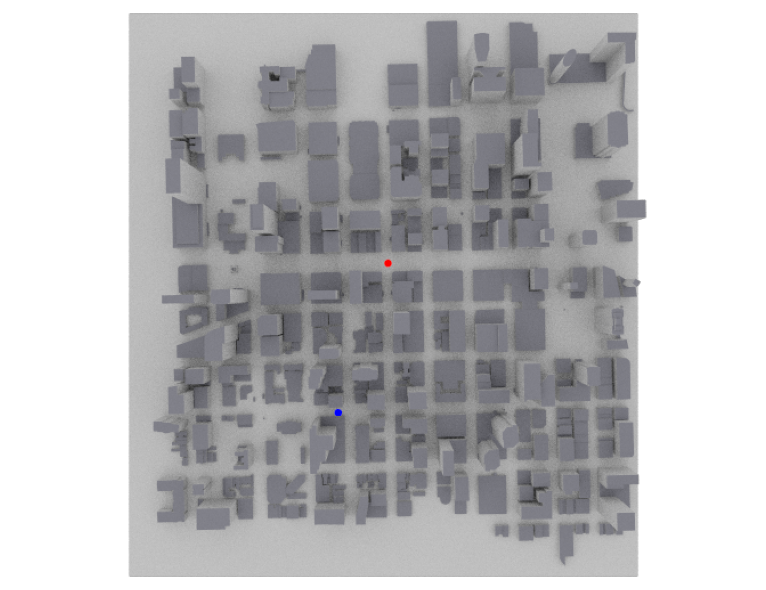

In [6]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=2, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)


tx_2 = Transmitter(name="Tx2", position=[-260,100,10], color=[0.0, 0.0, 1.0])
scene.add(tx_2)


# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

In [7]:
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

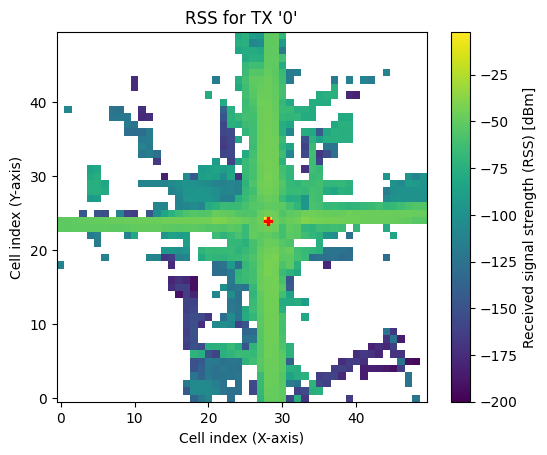

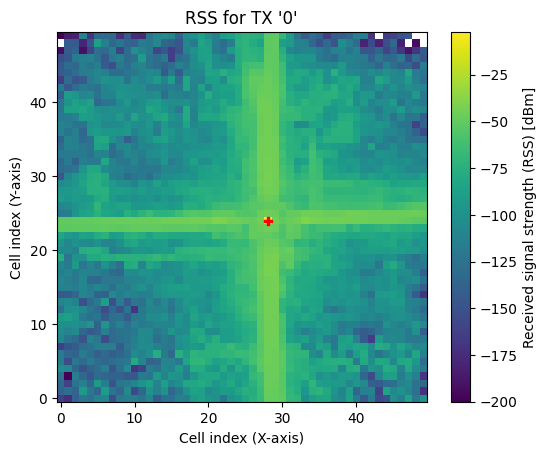

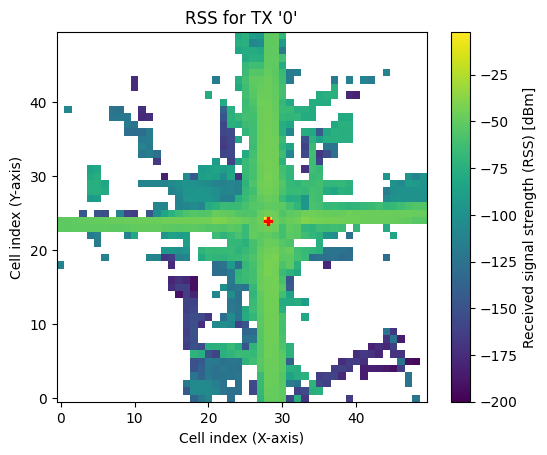

In [8]:
rm = rm_solver(
    scene,
    max_depth=25,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

# RM with max depth 3 for comparison
rm_3 = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True,
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-200)
rm_3.show(metric="rss", tx=0, show_tx=True, vmin=-200)

# rss = np.array(rm.rss)
# print(f"{np.log(rss)}")

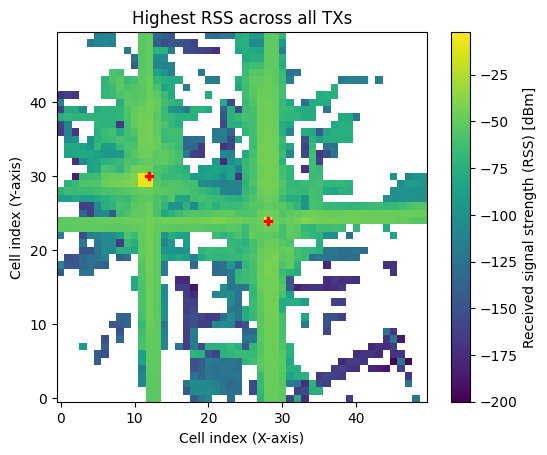

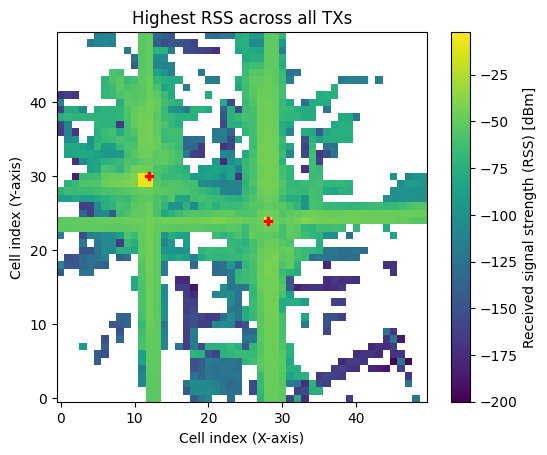

In [9]:
rm_2tx = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm_2tx.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [10]:
scene.preview(radio_map=rm, rm_vmin=-160)

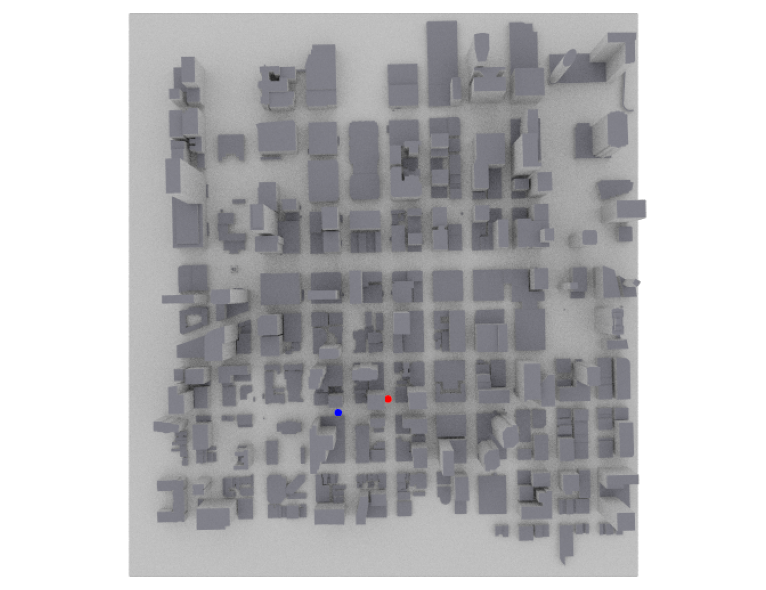

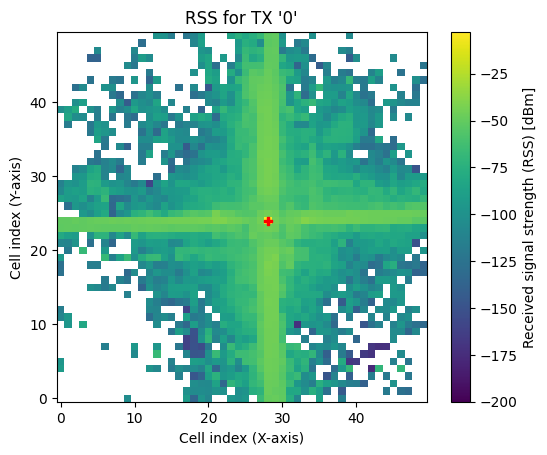

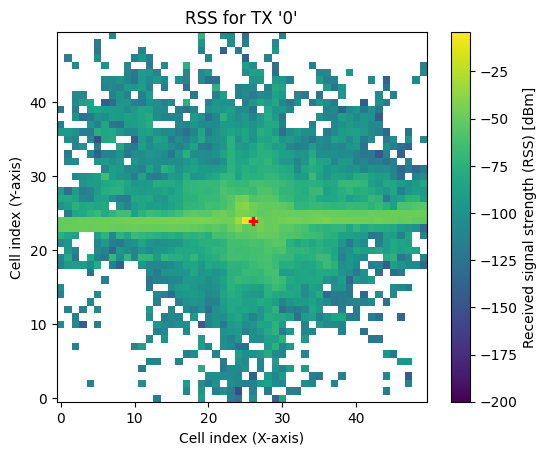

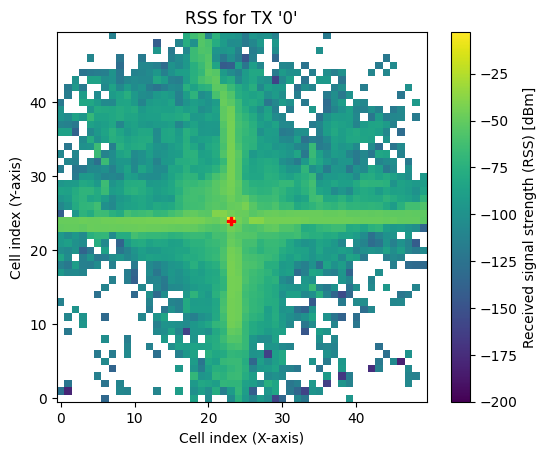

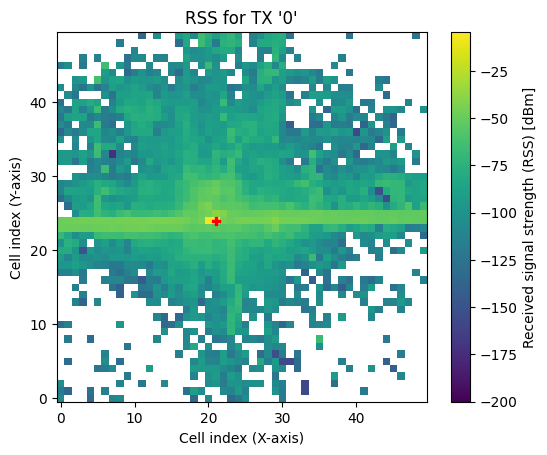

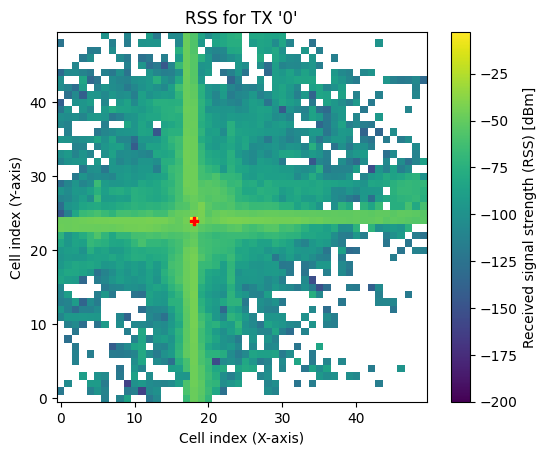

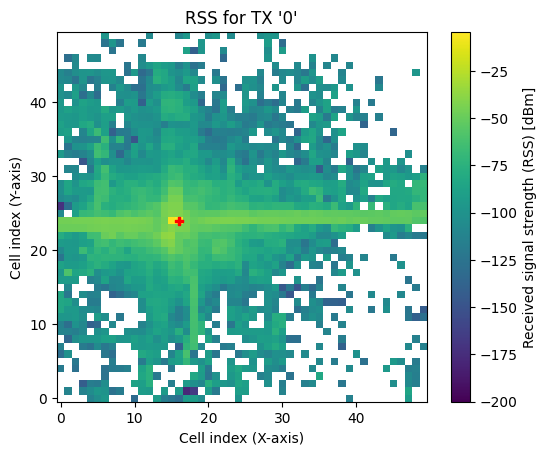

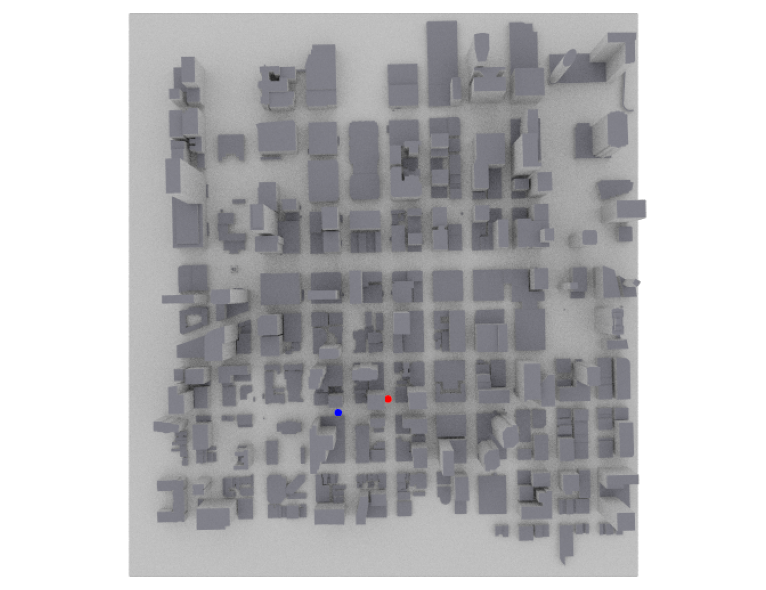

In [11]:
# --------------------------Moving Transmitters----------------------------#

displacement_vec = [50, 0, 0]
num_displacements = 5

for _ in range(num_displacements+1):
    rm_mobile = rm_solver(
    scene,
    max_depth=10,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**6,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
    ) 
    
    scene.get("Tx1").position -= displacement_vec
    rm_mobile.show(metric="rss", tx=0, show_tx=True, vmin=-200)

    
scene.render(camera=cam)

In [18]:
print(scene.get("Chicago_Water_Tower-itu_concrete").position)

[[57.4695, 330.09, 14.2926]]
